In this notebook I will try to fit a single star PSF model to a calibrator star from kernel phase data set. 
To do that I will need to fit only x, y center positions and median flux as in de Furio paper. In addition to that we I can add phase retrieval and improve model-data fitting

To fit a binary model, which I will do in a separate notebook, I will need to have more parameters, but first basic parameters are  x and y center of the primary, flux normalization of the primary, separation between the centers of the primary and secondary, the position angle of the center of the secondary relative to the primary, and the flux ratio between the secondary and primary. On top of that I can add phase retrieval parameters to the model. 

Functions I need:
1. grid search in x,y parameter space
2. plots to save
3. data for plots to be saved
4. de furio like 3x3 plot with fitting single and binary models to the binary data
5. sbatch run file
6. repeate code for every filter

In [3]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

import dLux as dl
from matplotlib import colors, pyplot as plt
import jax.numpy as np
from jax import jit, vmap
import jax.random as jr

import webbpsf
from astropy.io import fits
import astropy.units as u
from tqdm.notebook import tqdm

from dLuxWebbpsf import NIRCam

Step 1: Make fake data with the same parameters as real data.

In [43]:
webb_options = {
    'jitter': None,   # jitter model name or None
    'jitter_sigma': 0.000,  # in arcsec per axis, default 0.007
    'add_distortion': False,
}

optics = NIRCam(filter = "F300M",
                pupil_mask = None,
                coron_mask = None,
                detector = "NRCA5",
                aperture = "NRCA5_FULL_MASK430R",
                fft_oversample=1,
                fov_arcsec=None,
                fov_pixels=56,
                options=webb_options)

wavels, weights = optics.get_wavelengths()

spec = dl.Spectrum(wavels, weights)


source_offset_x = 0.1 *  np.pi/(180*3600)
source_offset_y = 0.25 *  np.pi/(180*3600)
offset = np.array([source_offset_x, source_offset_y])

#offset = np.array([-source_offset_y, source_offset_x / 47 * np.pi]) #test with different offset later
#offset = np.array([0,0])

# wavelengths are still required even if they are discarded
source = dl.PointSource(wavelengths=wavels, spectrum=spec, position=offset)


telescope = dl.Instrument(optics, (source,'source'))

Step 2: Make an optical model for optimisation where source will be parametrised.

the solution that they have for this same problem in https://github.com/amerand/CANDID, a popular interferometry data analysis code, is to calculate the likelihood on a grid of xy with other parameters held constant, to identify the best position to start
see that page - scroll down to ‘CHI2MAP’ and ‘FITMAP’

In [44]:
@jit
def model_optics_jit():
    return telescope.model()

In [45]:
%%time
print("Modelling optics...")
psf = model_optics_jit()
print("Modelling optics...ok")

Modelling optics...
Modelling optics...ok
CPU times: user 653 ms, sys: 128 ms, total: 781 ms
Wall time: 360 ms


In [46]:
psf_photon = 1*jr.poisson(jr.PRNGKey(0), psf)
bg_noise = 0.01*jr.normal(jr.PRNGKey(0), psf_photon.shape)
data = psf_photon + bg_noise

(56, 56)


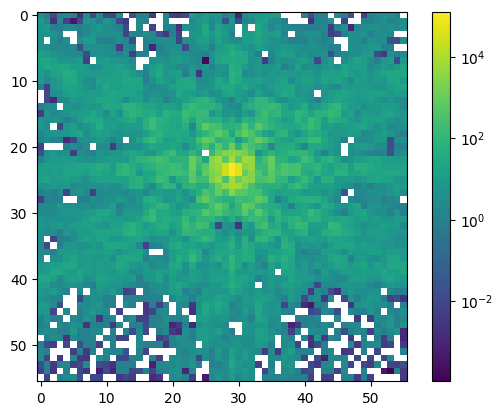

In [47]:
plt.imshow(data, norm="log")
plt.colorbar()
print(data.shape)

In [68]:
parameters = ['source.position']

# Define the likelihood function
model = telescope

# Define the meshgrid
xsize = 21
ysize = 21
allsize = xsize*ysize

xmin = -1 * np.pi/(180*3600)
xmax = 1 * np.pi/(180*3600)
ymin = -1 * np.pi/(180*3600)
ymax = 1 * np.pi/(180*3600)

xx, yy = np.meshgrid(np.linspace(xmin, xmax, xsize), np.linspace(ymin, ymax, ysize))

xr = xx.reshape((allsize))
yr = yy.reshape((allsize))


In [69]:
#this works but slower

#@jit
#def likelihood(x, y, expected_data):
#    model_data = model.set(parameters, [[x, y]]).model()
#    residuals = expected_data - model_data
#    # calculate the chi-squared value
#    chi_squared = np.sum(residuals**2)
#    # calculate the likelihood
#    likelihood =  -0.5 * chi_squared  #log likelihood
#    return likelihood

#%%time
#likelihoods_list = []
#for x, y, token in zip(xr, yr, tqdm(range(allsize))):
#    LH = likelihood(x, y, data)
#    likelihoods_list.append(LH)
#    residuals = data - model.set(parameters, [[x, y]]).model()
#    chi_squared = np.sum(residuals**2)
#    print(f"x={x}, y={y}, chi_squared={chi_squared}, likelihood={LH}")

#likelihoods = np.array(likelihoods_list).reshape((xsize, ysize))

In [70]:
from jax import lax

def likelihood(x, y, expected_data):
    model_data = model.set(parameters, [[x, y]]).model()
    residuals = expected_data - model_data
    # calculate the chi-squared value
    chi_squared = np.sum(residuals**2)
    # calculate the likelihood
    likelihood =  -0.5 * chi_squared  #log likelihood
    print(f"x={x}, y={y}, chi_squared={chi_squared}")
    return likelihood

@jit
def likelihood_fast(x,y,expected_data):
    likelihood_c = lambda args : likelihood(args[0], args[1], expected_data)
    args = np.stack((x, y), axis=-1)
    return lax.map(likelihood_c, args)


In [71]:
%%time
out = likelihood_fast(xr, yr, data)

x=Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>, y=Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>, chi_squared=Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>
CPU times: user 3min 4s, sys: 3.15 s, total: 3min 7s
Wall time: 35.3 s


In [72]:
likelihoods = np.array(out).reshape((xsize, ysize))
print(likelihoods)

ind_argmax = out.argmax()
coords=(xr[ind_argmax], yr[ind_argmax])

#ind_max = np.unravel_index(likelihoods.argmax(), likelihoods.shape)
#coords=(xx[ind_max[0], ind_max[1]], yy[ind_max[0], ind_max[1]])

x_recovered = coords[0] / np.pi * (180*3600)
y_recovered = coords[1] / np.pi * (180*3600)

print(x_recovered, y_recovered)

[[-3.69850525e+10 -3.71815464e+10 -3.71753912e+10 -3.69895200e+10
  -3.73114754e+10 -3.69466361e+10 -3.72458361e+10 -3.70960576e+10
  -3.70429791e+10 -3.72703658e+10 -3.69255909e+10 -3.72900131e+10
  -3.70199246e+10 -3.71157578e+10 -3.72176654e+10 -3.69528091e+10
  -3.73154385e+10 -3.69718612e+10 -3.71993176e+10 -3.71561773e+10
  -3.70042945e+10]
 [-3.72149341e+10 -3.74133561e+10 -3.74070008e+10 -3.72207285e+10
  -3.75423178e+10 -3.71737994e+10 -3.74710461e+10 -3.73276322e+10
  -3.72789873e+10 -3.75066521e+10 -3.71573954e+10 -3.75036851e+10
  -3.72491492e+10 -3.73512462e+10 -3.74544838e+10 -3.71861208e+10
  -3.75438047e+10 -3.72010157e+10 -3.74294663e+10 -3.73883118e+10
  -3.72360717e+10]
 [-3.71250466e+10 -3.73237982e+10 -3.73186880e+10 -3.71332710e+10
  -3.74518943e+10 -3.70857302e+10 -3.73853217e+10 -3.72380021e+10
  -3.71931670e+10 -3.74187939e+10 -3.70652707e+10 -3.74083600e+10
  -3.71571997e+10 -3.72649797e+10 -3.73704787e+10 -3.70981824e+10
  -3.74549166e+10 -3.71112788e+10 -3.7

Step 3: Set up HMC parameters and distributions.

Step 4: Run HMC and make pretty plots.